In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pqr

# Предобработка данных

In [2]:
prices = pd.read_csv("factors/russia/close_price.csv", parse_dates=True, index_col=0)["2003":]

mcap = pd.read_csv("factors/russia/mcap.csv", parse_dates=True, index_col=0)["2003":]
pe = pd.read_csv("factors/russia/pe.csv", parse_dates=True, index_col=0)["2003":]

volume = pd.read_csv("factors/russia/trading_volume.csv", parse_dates=True, index_col=0)["2003":]
volume = prices * volume  # convert volume from lots to money

prices, mcap, pe, volume = pqr.utils.replace_with_nan(prices, mcap, pe, volume)
prices, mcap, pe, volume = pqr.utils.align(prices, mcap, pe, volume)

In [3]:
universe = volume >= 1_000_000
returns_calculator = pqr.utils.partial(
    pqr.calculate_returns, 
    universe_returns=pqr.prices_to_returns(prices),
)

benchmark = pqr.Benchmark.from_universe(
    universe=universe,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

In [4]:
table = pqr.metrics.Table()
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_return,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.volatility,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Volatility, %",
)
table.add_metric(
    pqr.metrics.max_drawdown,
    multiplier=100,
    name="Maximum Drawdown, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_excess_return,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Excess Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.alpha,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Alpha, %",
    
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.beta,
        benchmark=benchmark,
        statistics=True,
    ),
    precision=2,
    name="Monthly Beta, %",
)

fig = pqr.metrics.Figure(
    pqr.metrics.compounded_returns,
    name="Compounded Returns",
    benchmark=benchmark,
    kwargs={
        "figsize": (10, 6),
    }
)

summary = pqr.metrics.Dashboard([table, fig])

In [5]:
mean_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.filter, universe=universe),
    pqr.utils.partial(pqr.factors.look_back_mean, period=3),
    pqr.utils.partial(pqr.factors.hold, period=3),
)
size = mean_transform(mcap)
value = mean_transform(pe)

Сначала строим однофакторные портфели по топ 20%

,Size,Value
"Monthly Mean Return, %",1.49*** (2.39),1.48*** (2.81)
"Monthly Volatility, %",9.27,7.86
"Maximum Drawdown, %",-80.45,-60.48
"Monthly Mean Excess Return, %",0.09 (0.23),0.08 (0.28)
"Monthly Alpha, %",-0.00 (-0.00),0.12 (0.45)
"Monthly Beta, %",1.06*** (19.49),0.97*** (24.43)


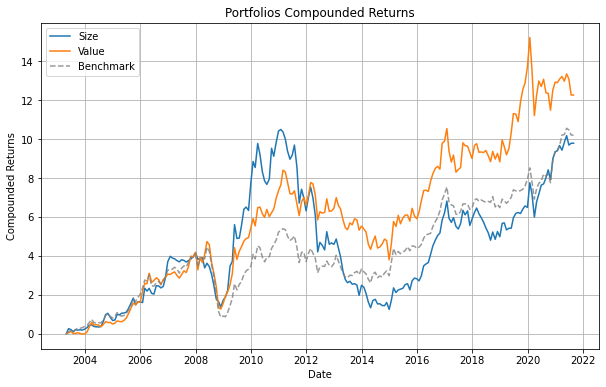

In [6]:
size_portfolio = pqr.Portfolio.backtest(
    longs=pqr.factors.quantiles(size, min_q=0, max_q=0.2),
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Size",
)

value_portfolio = pqr.Portfolio.backtest(
    longs=pqr.factors.quantiles(value, min_q=0, max_q=0.2),
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Value",
)

summary.display([size_portfolio, value_portfolio])

# Weighted Multifactor

Все просто - сводим мульифакторный выбор к 1-факторному

,Size,Value,Size + Value Weighted
"Monthly Mean Return, %",1.49*** (2.39),1.48*** (2.81),1.65*** (2.68)
"Monthly Volatility, %",9.27,7.86,9.16
"Maximum Drawdown, %",-80.45,-60.48,-73.75
"Monthly Mean Excess Return, %",0.09 (0.23),0.08 (0.28),0.25 (0.67)
"Monthly Alpha, %",-0.00 (-0.00),0.12 (0.45),0.17 (0.44)
"Monthly Beta, %",1.06*** (19.49),0.97*** (24.43),1.06*** (19.97)


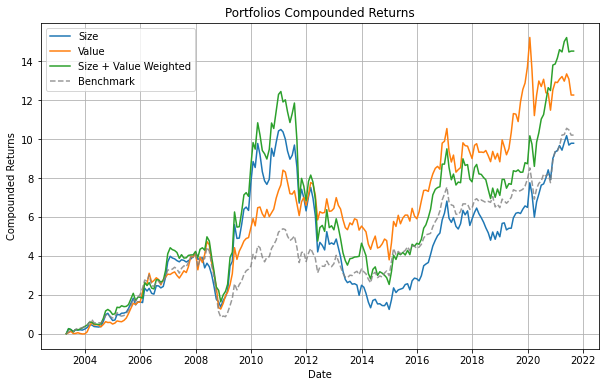

In [7]:
size_value_weighted_portfolio = pqr.Portfolio.backtest(
    longs=pqr.factors.quantiles(0.5 * size + 0.5 * value, min_q=0, max_q=0.2),
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Size + Value Weighted"
)
summary.display([size_portfolio, value_portfolio, size_value_weighted_portfolio])

# Intercept Multifactor

,Size,Value,Size + Value Weighted,Size + Value Intercept
"Monthly Mean Return, %",1.49*** (2.39),1.48*** (2.81),1.65*** (2.68),1.46*** (2.35)
"Monthly Volatility, %",9.27,7.86,9.16,9.24
"Maximum Drawdown, %",-80.45,-60.48,-73.75,-69.11
"Monthly Mean Excess Return, %",0.09 (0.23),0.08 (0.28),0.25 (0.67),0.06 (0.09)
"Monthly Alpha, %",-0.00 (-0.00),0.12 (0.45),0.17 (0.44),0.70 (1.21)
"Monthly Beta, %",1.06*** (19.49),0.97*** (24.43),1.06*** (19.97),0.54*** (6.59)


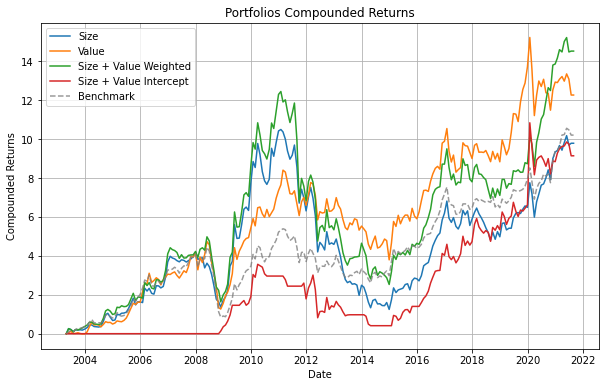

In [8]:
size_value_intercept_portfolio = pqr.Portfolio.backtest(
    longs=pqr.factors.quantiles(size, min_q=0, max_q=0.2) & 
            pqr.factors.quantiles(value, min_q=0, max_q=0.2),
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Size + Value Intercept",
)

summary.display([
    size_portfolio, 
    value_portfolio, 
    size_value_weighted_portfolio, 
    size_value_intercept_portfolio
])

# Double Sort Multifactor

,Size,Value,Size + Value Weighted,Size + Value Intercept,Size -> Value Double Sort,Value -> Size Double Sort
"Monthly Mean Return, %",1.49*** (2.39),1.48*** (2.81),1.65*** (2.68),1.46*** (2.35),2.50*** (2.61),2.30*** (2.96)
"Monthly Volatility, %",9.27,7.86,9.16,9.24,14.26,11.58
"Maximum Drawdown, %",-80.45,-60.48,-73.75,-69.11,-82.88,-69.93
"Monthly Mean Excess Return, %",0.09 (0.23),0.08 (0.28),0.25 (0.67),0.06 (0.09),1.10* (1.55),0.90* (1.57)
"Monthly Alpha, %",-0.00 (-0.00),0.12 (0.45),0.17 (0.44),0.70 (1.21),0.45 (0.65),0.71 (1.21)
"Monthly Beta, %",1.06*** (19.49),0.97*** (24.43),1.06*** (19.97),0.54*** (6.59),1.46*** (15.02),1.13*** (13.79)


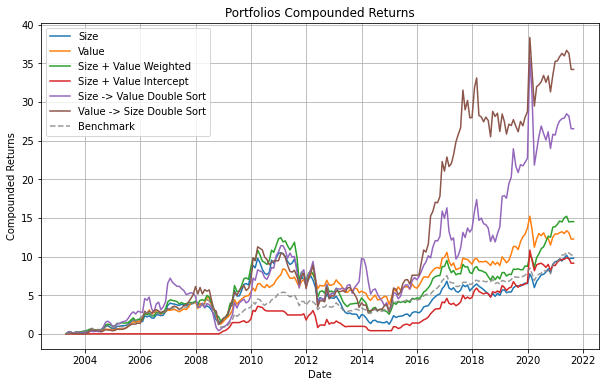

In [9]:
def double_sort(f1, f2):
    return pqr.factors.quantiles(
        pqr.factors.filter(f2, universe=pqr.factors.quantiles(f1, min_q=0, max_q=0.2)),
        min_q=0,
        max_q=0.2,
    )

size_value_double_sort_portfolio = pqr.Portfolio.backtest(
    longs=double_sort(size, value),
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Size -> Value Double Sort",
)

value_size_double_sort_portfolio = pqr.Portfolio.backtest(
    longs=double_sort(value, size),
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Value -> Size Double Sort",
)

summary.display([
    size_portfolio, value_portfolio, 
    size_value_weighted_portfolio, 
    size_value_intercept_portfolio,
    size_value_double_sort_portfolio,
    value_size_double_sort_portfolio
])